In [1]:
!git clone https://github.com/Miamoto/fruit-classifier

Cloning into 'fruit-classifier'...
remote: Enumerating objects: 14515, done.
remote: Counting objects: 100% (14515/14515), done.
remote: Compressing objects: 100% (14508/14508), done.
remote: Total 14515 (delta 12), reused 14487 (delta 5), pack-reused 0
Receiving objects: 100% (14515/14515), 63.08 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 23 11:07:57 2019

@author: anama
"""


import os
import keras
import random
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.layers import Dense,Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from IPython.display import display 
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet

train_data_dir = "fruit-classifier/dataset/Training"
test_data_dir = "fruit-classifier/dataset/Test"
weights_filename = "weights.hdf5"


nb_batch_size = 128

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


list_apples = ['Apple Crimson Snow','Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3',
               'Apple Granny Smith', 'Apple Red 1','Apple Red 2', 'Apple Red 3',
               'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2']
list_lemons = ['Lemon', 'Lemon Meyer']
list_pears = ['Pear Abate', 'Pear Kaiser', 'Pear Monster', 'Pear Red','Pear Williams']


def process_images(lst, root_dir):
    res = []
    for obj in lst:
        data_dir = root_dir + '/'+ obj
        for filename in os.listdir(data_dir):
          res.append(data_dir + "/" + filename)
    return res


train_set = []
train_set += process_images(list_apples,train_data_dir)
train_set += process_images(['Orange'], train_data_dir)
train_set += process_images(list_lemons, train_data_dir)
train_set += process_images(list_pears, train_data_dir)
random.shuffle(train_set)

test_set = []
test_set += process_images(list_apples,test_data_dir)
test_set += process_images(['Orange'], test_data_dir)
test_set += process_images(list_lemons, test_data_dir)
test_set += process_images(list_pears, test_data_dir)
random.shuffle(test_set)


train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) 
test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)


# default image size
img_height = 100
img_width = 100


X = [] #images
y = [] #labels
for img_path in train_set:
  X.append(cv2.resize(cv2.imread(img_path, cv2.IMREAD_COLOR)[:,:,::-1], dsize=(img_height, img_width),
                      interpolation=cv2.INTER_CUBIC)) #read the image
  if 'Apple' in img_path:
    y.append(0)
  elif 'Orange' in img_path:
    y.append(1)
  elif 'Lemon' in img_path:
    y.append(2)
  elif 'Pear' in img_path:
    y.append(3)


X = np.array(X)
y = np.array(y)


from sklearn.model_selection import train_test_split
#30% validation set, 70% training set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=2)

print("y_train", y_train)
print("Shape of train images is:", X_train.shape)
print("Shape of validation image", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of label", y_val.shape)

num_classes = 4
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

train_generator = train_datagen.flow(X_train, y_train,batch_size=nb_batch_size)
validation_generator = train_datagen.flow(X_val, y_val, batch_size=nb_batch_size)


base_model=MobileNet(include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
# preds=Dense(2,activation='softmax')(x) #final layer with softmax activation


predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

# set the added layers of the network to be non-trainable
for layer in base_model.layers:
  layer.trainable = False

Using TensorFlow backend.


y_train [3 3 3 ... 3 0 0]
Shape of train images is: (6555, 100, 100, 3)
Shape of validation image (2810, 100, 100, 3)
Shape of labels is: (6555,)
Shape of label (2810,)
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 8s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_b

In [0]:
def process_image(file):
    img_path = "MobileNet-inference-images/"
    img = image.load_image(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_expanded)
    
    

In [4]:
import math

y = to_categorical(y)
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(SGD(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

nb_steps_per_epoch = math.floor(X_train.shape[0]/nb_batch_size)
nb_validation_steps = math.floor(X_val.shape[0]/nb_batch_size)
print(nb_steps_per_epoch)
#checkpoint = ModelCheckpoint(weights_filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#history = model.fit_generator(train_generator, steps_per_epoch=4, validation_data = validation_generator, 
#                               validation_steps=2, epochs=50, verbose=2)
history = model.fit(X, y, validation_split=0.3, batch_size=16, epochs=20)

print("fim")

51
Instructions for updating:
Use tf.cast instead.
Train on 6555 samples, validate on 2810 samples
Epoch 1/20
6555/6555 [==============================] - 8s 1ms/step - loss: 1.0020 - acc: 0.6124 - val_loss: 1.0102 - val_acc: 0.6089
Epoch 2/20
6555/6555 [==============================] - 4s 602us/step - loss: 0.7876 - acc: 0.7106 - val_loss: 0.9978 - val_acc: 0.6018
Epoch 3/20
6555/6555 [==============================] - 4s 602us/step - loss: 0.6654 - acc: 0.7713 - val_loss: 1.0077 - val_acc: 0.6000
Epoch 4/20
6555/6555 [==============================] - 4s 601us/step - loss: 0.5705 - acc: 0.8212 - val_loss: 1.0312 - val_acc: 0.5993
Epoch 5/20
6555/6555 [==============================] - 4s 606us/step - loss: 0.4965 - acc: 0.8516 - val_loss: 1.0650 - val_acc: 0.5975
Epoch 6/20
6555/6555 [==============================] - 4s 611us/step - loss: 0.4431 - acc: 0.8731 - val_loss: 1.1024 - val_acc: 0.5918
Epoch 7/20
6555/6555 [==============================] - 4s 609us/step - loss: 0.3874 - 

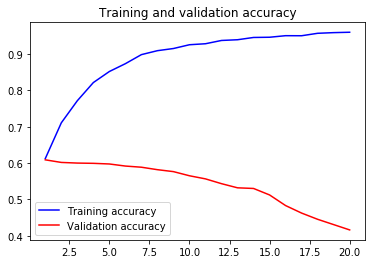

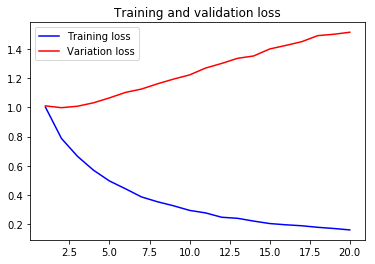

In [5]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Variation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [6]:
X_test = [] #images
y_test = [] #labels
for img_path in test_set:
  X_test.append(cv2.resize(cv2.imread(img_path, cv2.IMREAD_COLOR)[:,:,::-1], dsize=(img_height, img_width),
                      interpolation=cv2.INTER_CUBIC)) #read the image
  if 'Apple' in img_path:
    y_test.append(0)
  elif 'Orange' in img_path:
    y_test.append(1)
  elif 'Lemon' in img_path:
    y_test.append(2)
  elif 'Pear' in img_path:
    y_test.append(3)

X_test = np.array(X_test)
y_test = np.array(y_test)

y_test = to_categorical(y_test)
print(y_test)

#test_generator = test_datagen.flow(X_test, y_test, batch_size=20)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [7]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

correct_count = 0
for i in range(len(y_pred)):
  index = np.argmax(y_pred[i])
  if y_test[i][index] == 1:
    correct_count += 1
    
print("Accuracy = " + str(correct_count / len(y_pred)))

Accuracy = 0.41959157626037014
